# New York City
In this assignment you will visualize data about New York City (NYC) and compare it with the state of New York and the United States (US). You will use the American Community Survey (ACS) Public Use Microdata Sample (PUMS) dataset (1-year estimate from 2017). The data has been simplified to fit the objective of this data visualization assignment.

In particular, you are going to use two datasets - 'New York Population Records' (./data/pny.csv) and 'New York Housing Unit Records' (./data/hny.csv). The first dataset contains information about the New York population, and the second dataset contains information about housing units. The dataset contains data for about 1% of the population and housing units. Due to the extensive amount of data you are not using the datasets for the whole US, instead the required information related to the US is provided when necessary. 

Use the following code to import packages.

In [2]:

# import packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import squarify

sns.set()

Use pandas to read both csv-files located in the subdirectory 'data'.

In [4]:
p_ny = pd.read_csv('./data/pny.csv')
h_ny = pd.read_csv('./data/hny.csv')

You first need to divide the housing unit data into each district. Use the given PUMA (public use microdata area code based on 2010 Census definition which are areas with populations of 100,000 or more) ranges to further divide the dataset into NYC districts (Bronx, Manhatten, Staten Island, Brooklyn, and Queens).

In [5]:
# PUMA ranges for each district
bronx = [3701, 3710]
manhatten = [3801, 3810]
staten_island = [3901, 3903]
brooklyn = [4001, 4017]
queens = [4101, 4114]
nyc = [bronx[0], queens[1]]

# define a function to filter the data for each district
def puma_filter(data, puma_ranges):
    return data.loc[(data['PUMA'] >= puma_ranges[0]) & (data['PUMA'] <= puma_ranges[1])]

# housing unit data for each district
h_bronx = puma_filter(h_ny, bronx)
h_manhatten = puma_filter(h_ny, manhatten)
h_staten_island = puma_filter(h_ny, staten_island)
h_brooklyn = puma_filter(h_ny, brooklyn)
h_queens = puma_filter(h_ny, queens)

# housing unit and population data particularly for new york city
p_nyc = puma_filter(p_ny, nyc)
h_nyc = puma_filter(h_ny, nyc)

In the dataset each sample has a certain weight that reflects the weight for the total dataset. Therefore we cannot simply calculate the median. Use the given weighted_median function in the following to compute the median.

In [6]:
# function for a 'weighted' median - it takes two lists (values, weights), increase the frequency of value based on weight through np.repeat(), then combine all the values by extend()
def weighted_frequency(values, weights):
    weighted_values = []
    for value, weight in zip(values, weights):
        weighted_values.extend(np.repeat(value, weight))
    return weighted_values

# function to get the median of weighted frequency
def weighted_median(values, weights):
    return np.median(weighted_frequency(values, weights))

## Wages
In this subtask you will create a plot containing multiple subplots which visualize information about NYC wages.
- Visualize the weighted median household income for the US, New York, New York City, and its districts (housing unit data).
- Visualize the weighted average wage by gender for the given occupation categories for the population of NYC (population data).
- Visualize the weighted wage distribution for New York and NYC. We will use the following wage intervals: 10k steps between 0 and 100k, 50k steps between 100k and 200k, and >200k (population data)

### Column definitions
- ADJINC column is the inflation adjustment for incomes/wages (it should be divided by 1,000,000)
- WAGP column is the person's wage
- HINCP column is the household's income
- WGTP is the household weight for generating statistics on housing units and households
- PWGTP column is the person's weight for generating statistics on individuals
- OCCP column is occupation
- SEX column is gender

In [7]:
# data wrangling for median housing income
income_adjustement = h_ny.loc[0, ['ADJINC']].values[0] / 1e6

# use income and weight column, and get the weighted median using the funciton defined in the above
def median_housing_income(data):
    query = data.loc[np.isfinite(data['HINCP']), ['HINCP', 'WGTP']].values
    return np.round(weighted_median(query[:, 0], query[:, 1]) * income_adjustement)

# get median house income for each district, ny and nyc 
h_ny_income_median = median_housing_income(h_ny)
h_nyc_income_median = median_housing_income(h_nyc)
h_bronx_income_median = median_housing_income(h_bronx)
h_manhatten_income_median = median_housing_income(h_manhatten)
h_staten_island_income_median = median_housing_income(h_staten_island)
h_brooklyn_income_median = median_housing_income(h_brooklyn)
h_queens_income_median = median_housing_income(h_queens)

In [8]:
# data wrangling for wage by gender for different occupation categories
occ_categories = ['Management,\nBusiness,\nScience,\nand Arts\nOccupations', 'Service\nOccupations',
                 'Sales and\nOffice\nOccupations', 'Natural Resources,\nConstruction,\nand Maintenance\nOccupations',
                 'Production,\nTransportation,\nand Material Moving\nOccupations']
occ_ranges = {'Management, Business, Science, and Arts Occupations': [10, 3540], 'Service Occupations': [3600, 4650], 
                 'Sales and Office Occupations': [4700, 5940], 'Natural Resources, Construction, and Maintenance Occupations': [6000, 7630], 
                 'Production, Transportation, and Material Moving Occupations': [7700, 9750]}

# for each category of occupation defined above, get weighted average of wages
def wage_by_gender_and_occupation(data, gender):
    weighted_wages = []
    for occ in occ_ranges.values():
        query = data.loc[(data['OCCP'] >= occ[0]) & (data['OCCP'] <= occ[1]) & (data['SEX'] == gender), ['WAGP', 'PWGTP']]
        weight_sum = np.sum(query['PWGTP'])
        weighted_wages.append(np.round(np.sum(query['WAGP'] * (query['PWGTP'] / weight_sum))))
    return weighted_wages

# get the weitged average wages by job category and gender
wages_male = wage_by_gender_and_occupation(p_nyc, 1)
wages_female = wage_by_gender_and_occupation(p_nyc, 2)

In [9]:
# data wrangling for wage distribution
wage_bins = {'<$10k': [0, 10000], '$10-20k': [10000, 20000], '$20-30k': [20000, 30000], '$30-40k': [30000, 40000], '$10-20k': [40000, 50000],
            '$50-60k': [50000, 60000], '$60-70k': [60000, 70000], '$70-80k': [70000, 80000], '$80-90k': [80000, 90000], '$90-100k': [90000, 100000],
            '$100-150k': [100000, 150000], '$150-200k': [150000, 200000], '>$200k': [200000, np.infty]}

# function to get wage frequency - it gets the wage and weight columns, then for each wage bin, it gets the relative frequency - total weights in the wage bin / all weights 
def wage_frequency(data):
    valid = data.loc[np.isfinite(data['WAGP']) & (data['WAGP'] > 0), ['WAGP', 'PWGTP']] # only consider people who have a job: salary > 0
    overall_sum = np.sum(valid['PWGTP'].values)
    frequency = []
    for wage_bin in wage_bins.values():
        query = data.loc[(data['WAGP'] * income_adjustement > wage_bin[0]) & (data['WAGP'] * income_adjustement <= wage_bin[1]), ['PWGTP']].values
        frequency.append(np.sum(query) / overall_sum)
    return frequency

# get frequency for ny and nyc
wages_nyc = wage_frequency(p_nyc)
wages_ny = wage_frequency(p_ny)

### Task #1
The data now has been processed for creating the visualization plot with three subslots. Now it is your turn to create the visualizations from the generated data.

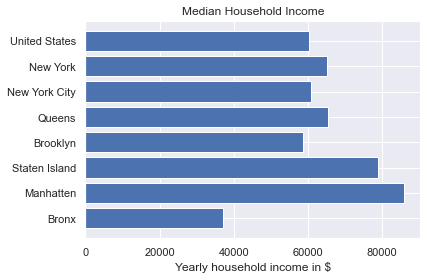

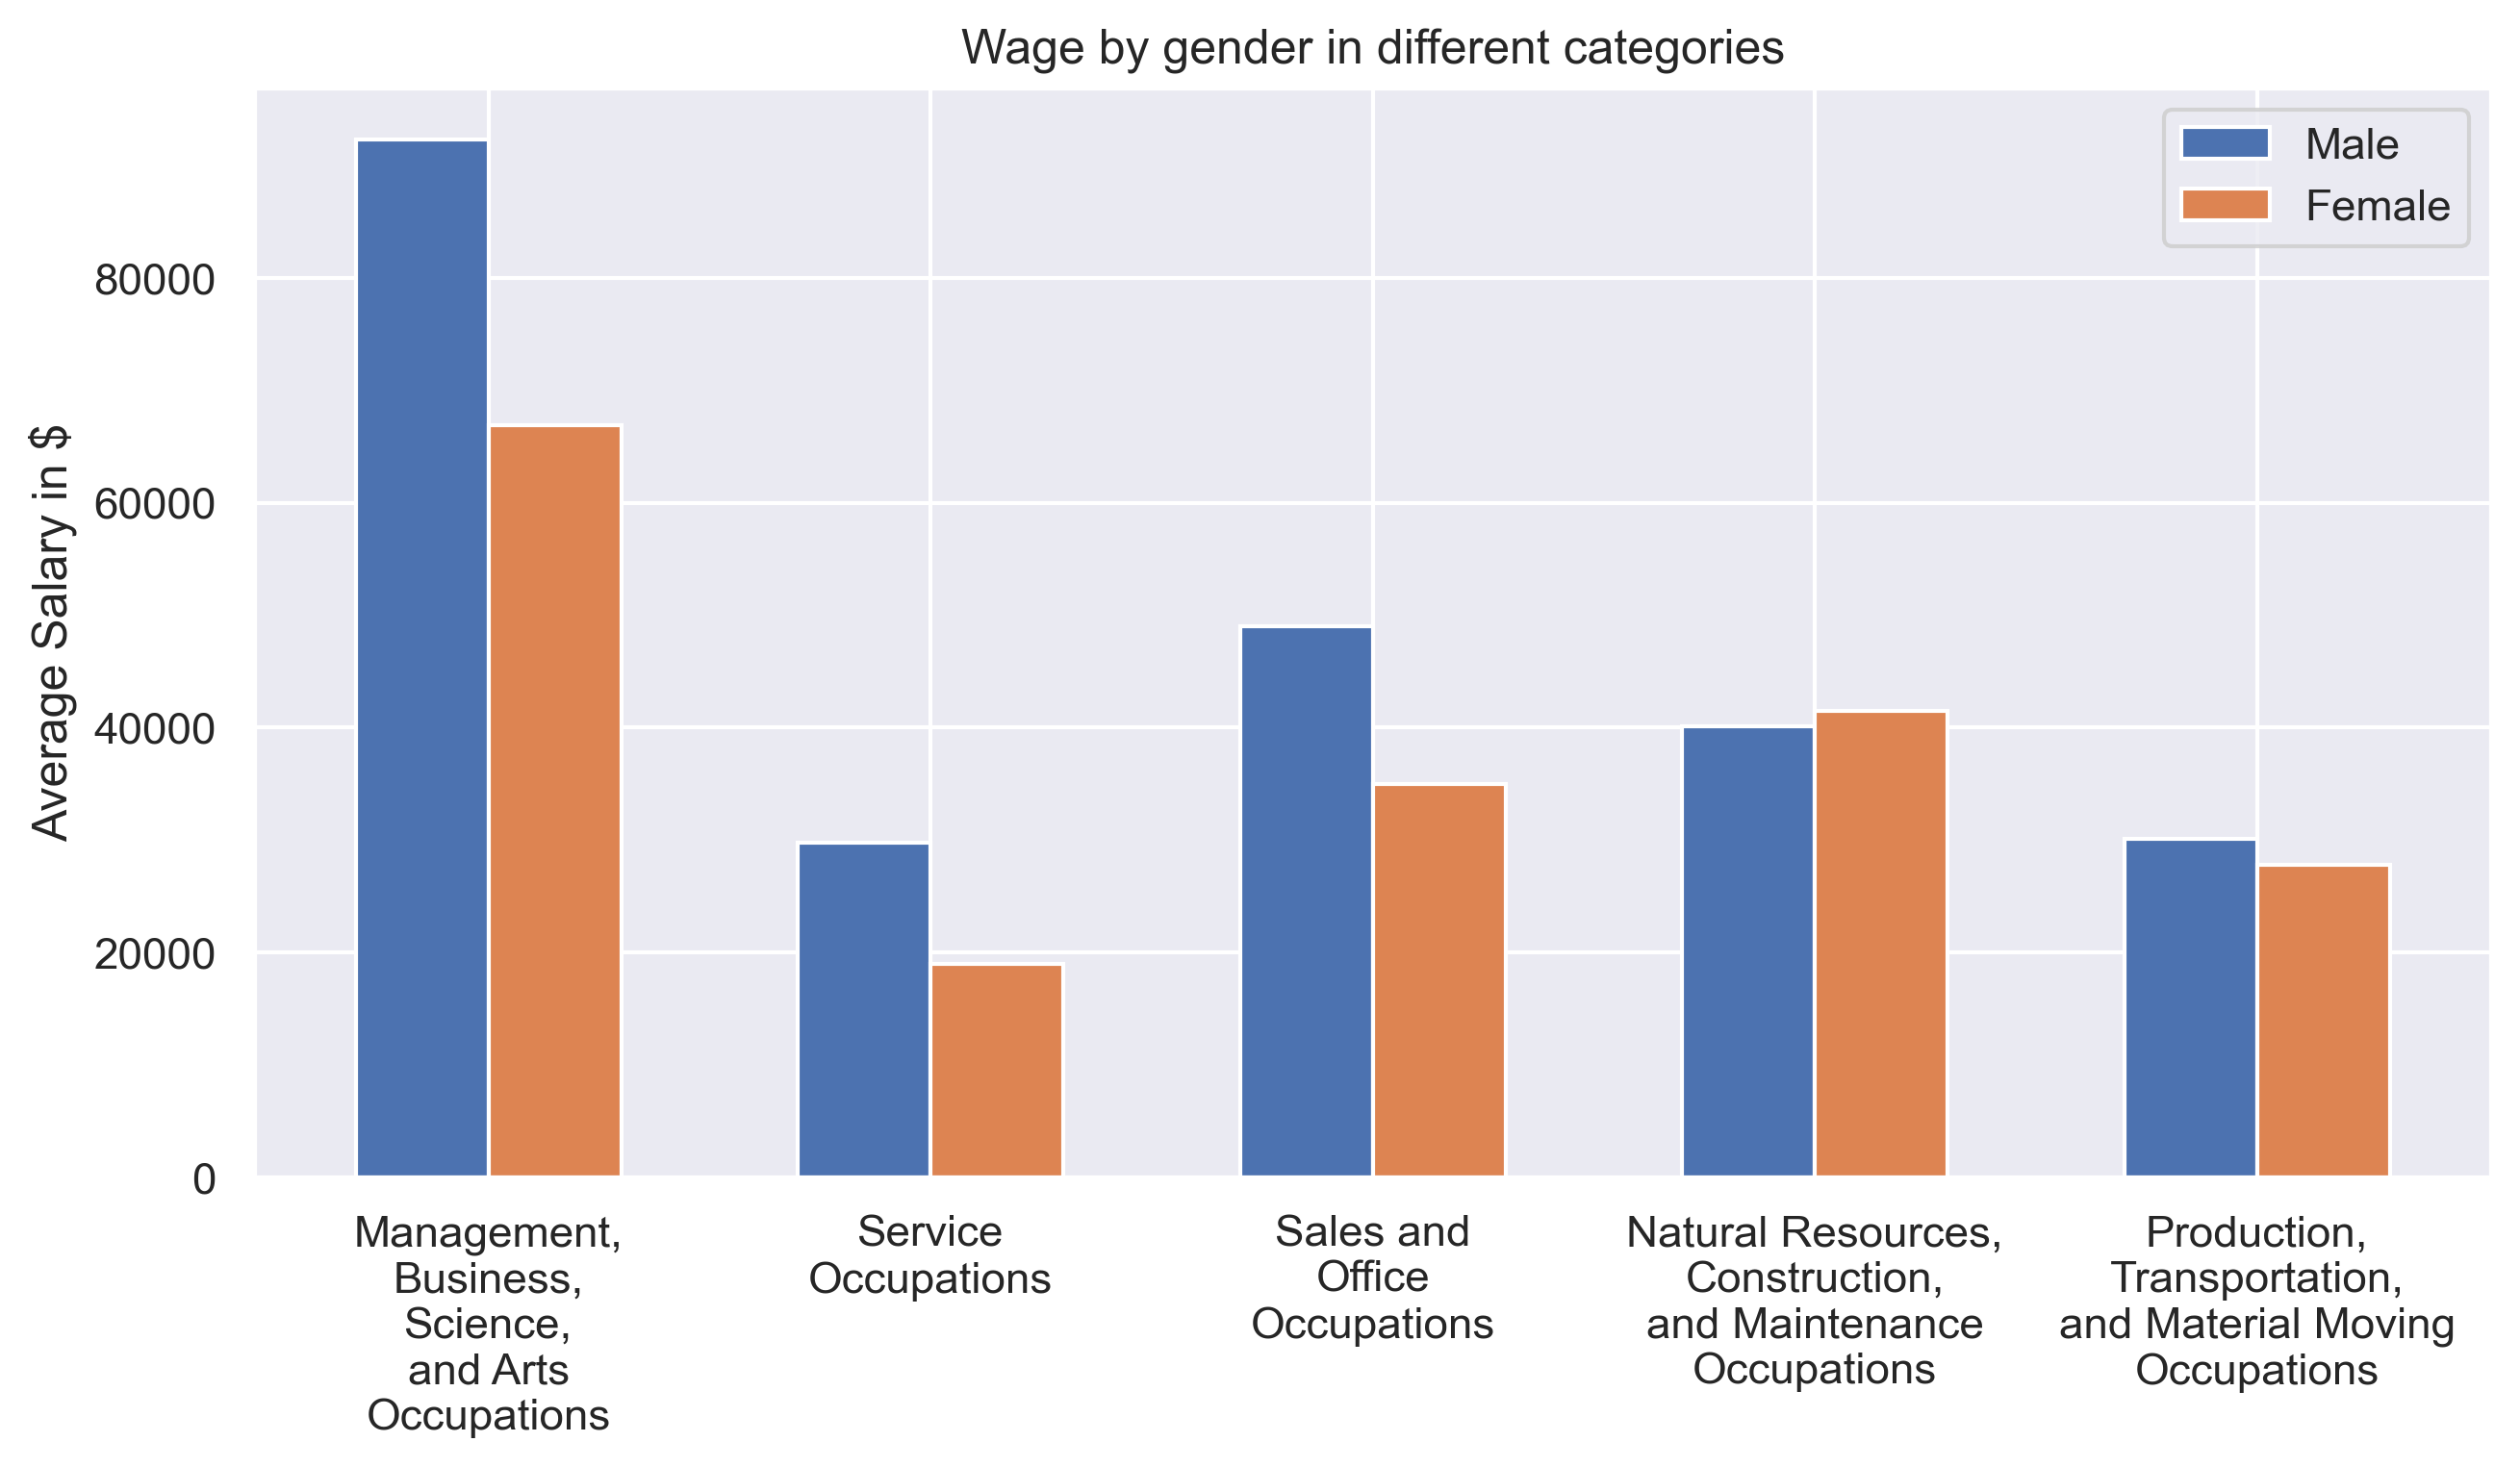

In [30]:
# Task 1 - create figure with three subplots


# median household income in the US for comparison
us_income_median = 60336

# subplot 1 - median household income
bars = ('United States', 'New York', 'New York City', 'Queens', 'Brooklyn', 'Staten Island', 'Manhatten','Bronx')
values_med_household_income= [us_income_median, h_ny_income_median, h_nyc_income_median, h_queens_income_median, h_brooklyn_income_median, h_staten_island_income_median, h_manhatten_income_median, h_bronx_income_median]
y_pos = np.arange(len(bars))

plt.barh(y_pos, values_med_household_income)

# Create names on the y-axis
plt.yticks(y_pos, bars)
plt.gca().invert_yaxis()
plt.xlabel('Yearly household income in $')
plt.title('Median Household Income')
plt.show()


 

 
#print(h_ny_income_median)
# subplot 2 - wage by gender in common jobs

%matplotlib inline
plt.figure(figsize=(10,5), dpi=300)
pos = np.arange(len(occ_ranges))
width = 0.3
plt.bar(pos - width / 2, wages_male, width, label='Male')
plt.bar(pos + width / 2, wages_female, width, label='Female')
plt.title('Wage by gender in different categories')
index=np.arange(len(occ_categories))
plt.xticks(index, occ_categories) 
plt.ylabel('Average Salary in $') 


plt.legend()
plt.show()
# subplot 3 - wage distribution


# overall figure



## Occupations
Next, you will use a tree map to visualize the percentage for the given occupation subcategories for the population of NYC.

In [10]:
# data wrangling for occupations
occ_subcategories = {'Management,\nBusiness,\nand Financial': [10, 950],
                    'Computer, Engineering,\nand Science': [1000, 1965],
                    'Education,\nLegal,\nCommunity Service,\nArts,\nand Media': [2000, 2960],
                    'Healthcare\nPractitioners\nand\nTechnical': [3000, 3540],
                    'Service': [3600, 4650],
                    'Sales\nand Related': [4700, 4965],
                    'Office\nand Administrative\nSupport': [5000, 5940],
                    '': [6000, 6130],
                    'Construction\nand Extraction': [6200, 6940],
                    'Installation,\nMaintenance,\nand Repair': [7000, 7630],
                    'Production': [7700, 8965],
                    'Transportation\nand Material\nMoving': [9000, 9750]}

# function to get occupation percentages - it gets all weights in the data, then sums all weights for each category of occupation, which is divided by total sum of weights
def occupation_percentage(data):
    percentages = []
    overall_sum = np.sum(data.loc[(data['OCCP'] >= 10) & (data['OCCP'] <= 9750), ['PWGTP']].values)
    for occ in occ_subcategories.values():
        query = data.loc[(data['OCCP'] >= occ[0]) & (data['OCCP'] <= occ[1]), ['PWGTP']].values
        percentages.append(np.sum(query) / overall_sum)
    return percentages

# get a list of occupation percentages by calling the function
occ_percentages = occupation_percentage(p_nyc)

In [11]:
# structuralize the generated data
df = pd.DataFrame({'percentage': occ_percentages, 'group': list(occ_subcategories.keys())})
df['group'] = df['group'] + ' (' + (np.round(df['percentage'] * 1000) / 10).astype('str') + '%)'

# set colors
blues = [matplotlib.cm.Blues((i + 2) * 30) for i in range(4)]
greens = [matplotlib.cm.Greens((i + 2) * 40) for i in range(1)]
oranges = [matplotlib.cm.Oranges((i + 2) * 40) for i in range(2)]
purples = [matplotlib.cm.Purples((i + 2) * 40) for i in range(3)]
reds = [matplotlib.cm.Reds((i + 2) * 40) for i in range(2)]
colors = blues + greens + oranges + purples + reds

### Task #2
Data for visualization now has been prepared. A set of colors is also defined. It is your turn to create the tree map visualization.

In [ ]:
# Task 2 - visualization of tree map for percentage of occupation




## Correlation


Next, you will use a heatmap to show the correlation between difficulties (self-care difficulty, hearing difficulty, vision, difficulty, independent living difficulty, ambulatory difficulty, veteran service connected disability, and cognitive difficulty) and age groups (<5, 5-11, 12-14, 15-17, 18-24, 25-34, 35-44, 45-54, 55-64, 65-74, 75+) in New York City.

In [13]:
# data wrangling for New York City population difficulties
difficulties = {'Self-care difficulty': 'DDRS', 'Hearing difficulty': 'DEAR',
               'Vision difficulty': 'DEYE', 'Independent living difficulty': 'DOUT',
               'Ambulatory difficulty': 'DPHY', 'Veteran service connected disability': 'DRATX',
               'Cognitive difficulty': 'DREM'}
age_groups = {'<5': [0, 4], '5-11': [5, 11], '12-14': [12, 14], '15-17': [15, 17], '18-24': [18, 24], '25-34': [25, 34],
             '35-44': [35, 44], '45-54': [45, 54], '55-64': [55, 64], '65-74': [65, 74], '75+': [75, np.infty]}

# for each 
def difficulty_age_array(data):
    array = np.zeros((len(difficulties.values()), len(age_groups.values())))
    for d, diff in enumerate(difficulties.values()):
        for a, age in enumerate(age_groups.values()):
            age_sum = np.sum(data.loc[(data['AGEP'] >= age[0]) & (data['AGEP'] <= age[1]), ['PWGTP']].values)
            query = data.loc[(data['AGEP'] >= age[0]) & (data['AGEP'] <= age[1]) & (data[diff] == 1), ['PWGTP']].values
            array[d, a] = np.sum(query) / age_sum
    return array

array = difficulty_age_array(p_nyc)

### Task #3
A correlation matrix now has been generated. It captures relative percentage (you need to multiply 100 to get real percentage) of population for each type of difficulty and age grou. Now it is your turn to create the heatmap visualization. Use difficulties.keys() to retrieve the labels.

In [ ]:
# Task 3 - create heatmap for correlation between difficutly and age group

